需要先安装好`pytorch, transformers[torch]`

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

from lxml import etree
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F

In [4]:
from pytorch_transformers import BertTokenizer, BertForSequenceClassification

# 使用transformers的pytorch版本，下载预训练模型（或者提前下载配置）
tokenizer = BertTokenizer.from_pretrained('bert-base-chinese')
model = BertForSequenceClassification.from_pretrained('bert-base-chinese', num_labels=3)
# BertForSequenceClassification 是一个基于BertModel的已经封装好可以直接使用的文本分类模型

100%|██████████| 411577189/411577189 [00:34<00:00, 11802745.75B/s]


In [5]:
# tokenizer 是把词标注成数字，[CLS] 101表示句子开始，[SEP] 102表示结束
tokenizer.encode('我爱北京天安门', add_special_tokens=True)

[101, 2769, 4263, 1266, 776, 1921, 2128, 7305, 102]

In [6]:
# 0 用来表示无意义词的填充
tokenizer.convert_tokens_to_ids("[PAD]")

0

### 数据的读入

新闻标题的情感判别，消极2，积极1，中性0

In [7]:
train = pd.read_excel('/kaggle/input/sentimental-analysis/TRAIN.xlsx', index_col=0)
del train['content']

In [8]:
train.head(2)

,texttitle,score
ID,,
0,(深互动)*ST佳电：因受到证监会行政处罚，导致公司2017年度信息披露考核为D,2
1,彭博：中国华融据悉计划重组海外业务 以削减成本,2


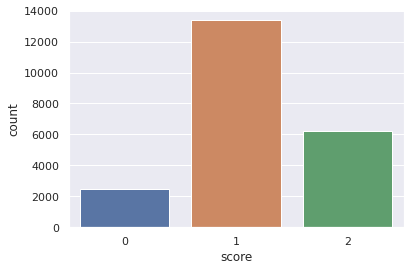

In [9]:
sns.countplot(train.score)

In [10]:
a = [torch.tensor(
    tokenizer.encode(title, add_special_tokens=True)) 
     for title in train['texttitle']]
maxlen = max(len(_) for _ in a); print(maxlen)

72


In [11]:
# 用 0 来做 padding
inputs = torch.stack(
    [torch.cat([t, torch.full(size=(maxlen - len(t), ), fill_value=0, dtype=torch.int64)])
     for t in a])

In [12]:
labels = torch.tensor(train['score'].values, dtype=torch.int64).unsqueeze(1)

In [13]:
inputs.shape, labels.shape

(torch.Size([22063, 72]), torch.Size([22063, 1]))

这里的`inputs`其实就是模型的输入，相当于只是把一句话的每个词编码之后加上句首和句尾的标记而已。

### 划分训练集和验证集

In [14]:
tx, vx, ty, vy = train_test_split(inputs, labels, random_state=2020, test_size=0.2)
ty_ = ty.numpy().squeeze()
vy_ = vy.numpy().squeeze()

# 使用gpu来训练
tx = tx.cuda()
vx = vx.cuda()
ty = ty.cuda()
vy = vy.cuda()

In [15]:
# 构建dataloader
train_set = torch.utils.data.TensorDataset(tx, ty)
val_set = torch.utils.data.TensorDataset(vx, vy)

train_loader = torch.utils.data.DataLoader(train_set, batch_size=32, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_set, batch_size=32, shuffle=False)

In [16]:
optimizer = torch.optim.Adam(model.parameters(), lr=3e-6)
_ = model.cuda()

### 模型的训练和评估

In [17]:
def model_train():
    model.train()
    ans = []
    for x, y in tqdm(train_loader):
        out = model(input_ids=x, labels=y)
        # 将input_ids和标签输入之后直接就能得到loss和结果(logits)
        # 这时候直接对loss进行反向传播就可以了！
        loss, logits = out[:2]
        ans.append(torch.argmax(logits, dim=1))  # logits 分别给出了每篇文本分成这三类的概率
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    ans = torch.cat(ans).cpu().numpy()
    acc = np.mean(ans == ty_)
    print(f'训练集上准确率: {acc}')
    return ans

In [18]:
@torch.no_grad()
def model_eval():
    model.eval()
    ans = []
    for x, y in val_loader:
        out = model(input_ids=x)
        ans.append(torch.argmax(out[0], dim=1))
    ans = torch.cat(ans).cpu().numpy()
    acc = np.mean(ans == vy_)
    print(f'验证集上准确率: {acc}')
    return ans

In [ ]:
for epoch in range(3):
    model_train()
    model_eval()

100%|██████████| 552/552 [02:14<00:00,  4.11it/s]


训练集上准确率: 0.5264022662889518


  0%|          | 0/552 [00:00<?, ?it/s]

验证集上准确率: 0.7935644686154544


100%|██████████| 552/552 [02:12<00:00,  4.16it/s]


训练集上准确率: 0.486628895184136


  0%|          | 0/552 [00:00<?, ?it/s]

验证集上准确率: 0.8037616134149105


 85%|████████▍ | 468/552 [01:52<00:20,  4.20it/s]

最后这个cell没有显示清楚，虽然训练集上效果不好，但是验证集上效果好啊。
这里只是简单的用了一下BertForSequenceClassification.
（事实上，这里的金融新闻人工来分都很难分对。）